### Glass Type Classification


Documentation: Dr. Bengfort's Wheat Classification lab


This notebook explore some classification methods on Glass Identification Data Set from UCI's Machine Learning repository (https://archive.ics.uci.edu/ml/datasets/glass+identification)
The data set provides details about 6 types of glass, defined in terms of their oxide content (i.e. Na, Fe, K, etc).


The dataset description is as follows:

Data Set: Multivariate
Attribute: Real
Associated Tasks: Classification
Number of Instances: 214
Number of Attributes: 10



### Data Set Information:

Vina conducted a comparison test of her rule-based system, BEAGLE, the nearest-neighbor algorithm, and discriminant analysis. BEAGLE is a product available through VRS Consulting,Inc. In determining whether the glass was a type of "float" glass or not, the following results were obtained (# incorrect answers):

Type of Sample -- Beagle -- NN -- DA
Windows that were float processed (87) -- 10 -- 12 -- 21
Windows that were not: (76) -- 19 -- 16 -- 22

The study of classification of types of glass was motivated by criminological investigation. At the scene of the crime, the glass left can be used as evidence...if it is correctly identified.

Attribute Information or the columns in this dataset are:

- Id number: 1 to 214
- RI: refractive index
- Na: Sodium
- Mg: Magnesium
- Al: Aluminum
- Si: Silica
- K: Potassium
- Ca: Calcium
- Ba: Barium
- Fe: Iron

Type of glass (Target label)


The Target label, Type of Glass has 6 classes:

1: building_windows_float_processed

2: building_windows_non_float_processed

3: vehicle_windows_float_processed

5: containers

6: tableware

7: headlamps

### Importing the libraries

In [11]:
%matplotlib inline
import missingno as msno

import os
import json
import time
import pickle
import requests


import numpy as np
import pandas as pd
import seaborn as sns
sns.set(style="whitegrid")
import matplotlib.pyplot as plt

from cycler import cycler
from sklearn import metrics
from sklearn.datasets.base import Bunch
from sklearn.model_selection import KFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression, SGDClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split as tts
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

from yellowbrick.features import Rank1D
from yellowbrick.features import Rank2D
from yellowbrick.classifier import ClassificationReport
from yellowbrick.features.importances import FeatureImportances




import warnings
warnings.filterwarnings('ignore')

### Getting Data

In [12]:
URL = "https://archive.ics.uci.edu/ml/machine-learning-databases/glass/glass.data"


def fetch_data(fname='glass.csv'):
    
    response = requests.get(URL)
    outpath  = os.path.abspath(fname)
    with open(outpath, 'wb') as f:
        f.write(response.content)
    
    return outpath

# Fetch the data if required
DATA = fetch_data()

### Reading Files, Selecting Columns, Summarizing, and Feature Selection

In [13]:
FEATURES  = [
    'id_number', 
    'ri', 
    'na', 
    'mg', 
    'al', 
    'si', 
    'k', 
    'ca', 
    'ba', 
    'fe', 
    'class'
]

CLASS_LABEL_MAP = {
    1: 'building_windows_float_processed' ,
    2: 'building_windows_non_float_processed' ,
    3: 'vehicle_windows_float_processed' ,
    4: 'vehicle_windows_non_float_processed' ,
    5: 'containers' ,
    6: 'tableware' ,
    7: 'headlamps' ,
}
                   
# Read the data into a DataFrame
df = pd.read_csv(DATA, header=None, names=FEATURES)

# Convert class labels into text
df['class'] = df['class'].map(CLASS_LABEL_MAP)

# Describe the dataset
print(df.describe(include='all'))

         id_number          ri          na          mg          al  \
count   214.000000  214.000000  214.000000  214.000000  214.000000   
unique         NaN         NaN         NaN         NaN         NaN   
top            NaN         NaN         NaN         NaN         NaN   
freq           NaN         NaN         NaN         NaN         NaN   
mean    107.500000    1.518365   13.407850    2.684533    1.444907   
std      61.920648    0.003037    0.816604    1.442408    0.499270   
min       1.000000    1.511150   10.730000    0.000000    0.290000   
25%      54.250000    1.516523   12.907500    2.115000    1.190000   
50%     107.500000    1.517680   13.300000    3.480000    1.360000   
75%     160.750000    1.519157   13.825000    3.600000    1.630000   
max     214.000000    1.533930   17.380000    4.490000    3.500000   

                si           k          ca          ba          fe  \
count   214.000000  214.000000  214.000000  214.000000  214.000000   
unique         NaN 

In [14]:
# Column index
df.columns

Index(['id_number', 'ri', 'na', 'mg', 'al', 'si', 'k', 'ca', 'ba', 'fe',
       'class'],
      dtype='object')

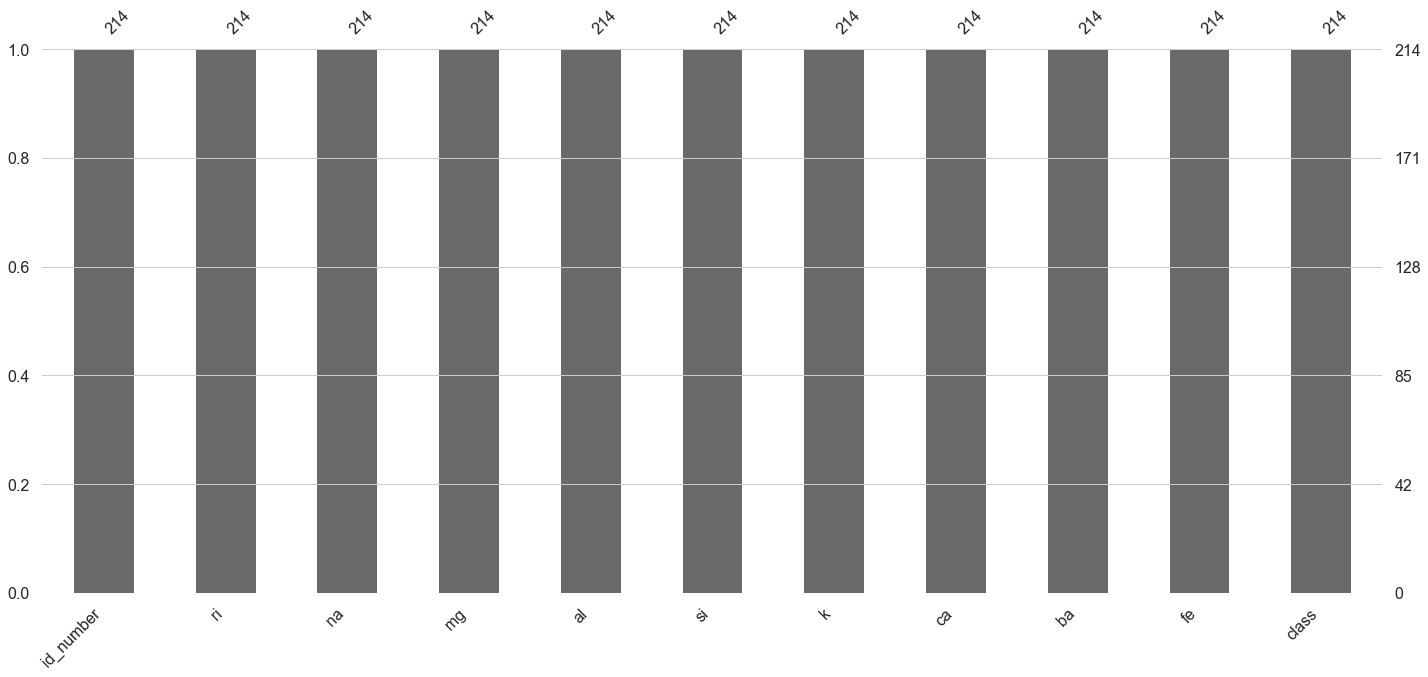

In [16]:
# Visualizing the number of missing values as a bar chart 
msno.bar(df)

In [17]:
# Alternatively, we can see the number of missing values like this
df.isnull().sum()

id_number    0
ri           0
na           0
mg           0
al           0
si           0
k            0
ca           0
ba           0
fe           0
class        0
dtype: int64

In [18]:
# Determine the shape of the data
print("{} instances with {} features\n".format(*df.shape))

# Determine the frequency of each class
print(pd.crosstab(index=df['class'], columns="count"))

214 instances with 11 features

col_0                                 count
class                                      
building_windows_float_processed         70
building_windows_non_float_processed     76
containers                               13
headlamps                                29
tableware                                 9
vehicle_windows_float_processed          17


Now that we have got a glimpse of the dataset, we know that it doesn't have any null values and all the attributes are continuous except the id_number is an integer.

In [19]:
from sklearn.preprocessing import LabelEncoder

# Extract our X and y data
X = df[FEATURES[1:-1]]
y = df['class']

# Encode our target variable
encoder = LabelEncoder().fit(y)
y = encoder.transform(y)

print(X.shape, y.shape)

(214, 9) (214,)


In [20]:
from sklearn.datasets.base import Bunch

DATA_DIR = os.getcwd()


In [21]:
def load_data(root=DATA_DIR):
    # Construct the `Bunch` for the glass dataset
    filenames     = {
        'meta': os.path.join(root, 'glassmeta.json'),
        'rdme': os.path.join(root, 'glass.names'),
        'data': os.path.join(root, 'glass.csv'),
    }

    # Load the meta data from the meta json
    with open(filenames['meta'], 'r') as f:
        meta = json.load(f)
        target_names  = meta['target_names']
        feature_names = meta['feature_names']

    # Load the description from the README. 
    with open(filenames['rdme'], 'r') as f:
        DESCR = f.read()

    # Load the dataset from the text file.
    dataset = np.loadtxt(filenames['data'], delimiter = ",")

   # Extract the target from the data
    data   = dataset[:, 1:-1]
    target = dataset[:, -1]

    # Create the bunch object
    return Bunch(
        data=data,
        target=target,
        filenames=filenames,
        target_names=target_names,
        feature_names=feature_names,
        DESCR=DESCR
    )

# Save the dataset as a variable we can use.
dataset = load_data()

print(dataset.data.shape)
print(dataset.target.shape)

(214, 9)
(214,)


In [22]:
X  = df.drop(['id_number','class'], axis=1)
y = df['class']

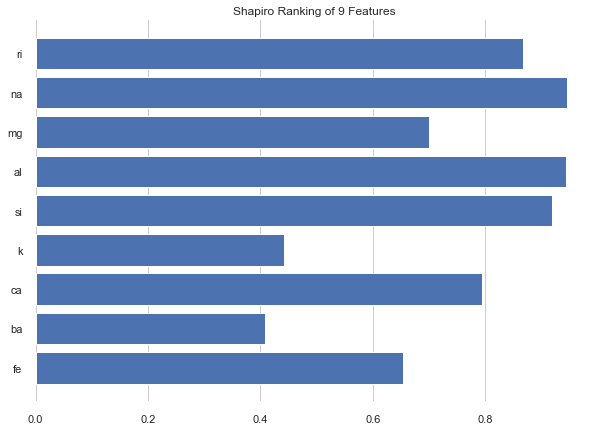

In [23]:
# Creating visualizer with the Sharpiro feature ranking algorithm
fig, ax = plt.subplots(figsize=(10,7))
visualizer = Rank1D(FEATURES=FEATURES, ax=ax, algorithm='shapiro')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)

visualizer.fit(X, y)
visualizer.transform(X)
visualizer.poof()

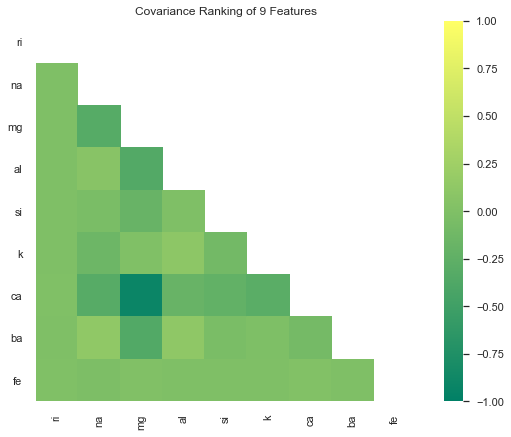

In [24]:
figsize=(10,7)
fig, ax = plt.subplots(figsize=figsize)
visualizer = Rank2D(FEATURES=FEATURES, ax=ax, algorithm='covariance', colormap='summer')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)

visualizer.fit(X, y)
visualizer.transform(X)
visualizer.poof()

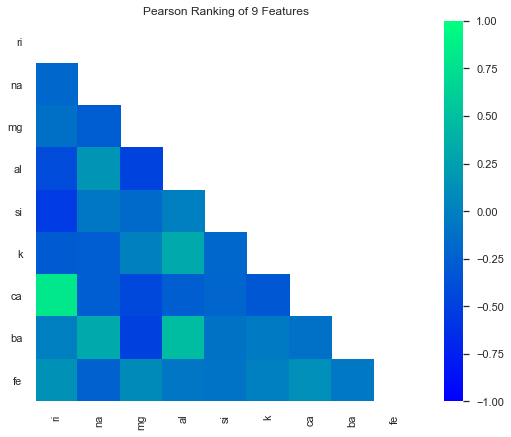

In [25]:
# Instantiate the visualizer with the Pearson ranking algorithm

figsize=(10,7)
fig, ax = plt.subplots(figsize=figsize)
visualizer = Rank2D(FEATURES=FEATURES, algorithm='pearson', colormap='winter')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)

visualizer.fit(X, y)
visualizer.transform(X)
visualizer.poof()

Based on visual feature importance visualization all features are important, features don’t leak excessive information to the model; therefore, we are not dropping features. Ri and Ca have strong correlation between each other.


### Classification

In [26]:
def fit_and_evaluate(dataset, model, label, **kwargs):
    """
    Because of the Scikit-Learn API, we can create a function to
    do all of the fit and evaluate work on our behalf!
    """
    start  = time.time() # Start the clock! 
    scores = {'precision':[], 'recall':[], 'accuracy':[], 'f1':[]}
    
    kf = KFold(n_splits = 12, shuffle=True)
    
    for train, test in kf.split(dataset.data):
        X_train, X_test = dataset.data[train], dataset.data[test]
        y_train, y_test = dataset.target[train], dataset.target[test]
        
        estimator = model(**kwargs)
        estimator.fit(X_train, y_train)
        
        expected  = y_test
        predicted = estimator.predict(X_test)
        
        # Append our scores to the tracker
        scores['precision'].append(metrics.precision_score(expected, predicted, average="weighted"))
        scores['recall'].append(metrics.recall_score(expected, predicted, average="weighted"))
        scores['accuracy'].append(metrics.accuracy_score(expected, predicted))
        scores['f1'].append(metrics.f1_score(expected, predicted, average="weighted"))

    # Report
    print("Build and Validation of {} took {:0.3f} seconds".format(label, time.time()-start))
    print("Validation scores are as follows:\n")
    print(pd.DataFrame(scores).mean())
    
    # Write official estimator to disk
    estimator = model(**kwargs)
    estimator.fit(dataset.data, dataset.target)
    
    outpath = label.lower().replace(" ", "-") + ".pickle"
    with open(outpath, 'wb') as f:
        pickle.dump(estimator, f)

    print("\nFitted model written to:\n{}".format(os.path.abspath(outpath)))

In [27]:
# Performing kNN Classification
fit_and_evaluate(dataset, KNeighborsClassifier, "Glass kNN Classifier", n_neighbors=12)

Build and Validation of Glass kNN Classifier took 0.036 seconds
Validation scores are as follows:

precision    0.615224
recall       0.626362
accuracy     0.626362
f1           0.596342
dtype: float64

Fitted model written to:
/Users/tamananaheeme/Desktop/GU_DS/glass-knn-classifier.pickle


In [28]:
# Performing Random Forest Classification
fit_and_evaluate(dataset,SVC,"SVC")

Build and Validation of SVC took 0.046 seconds
Validation scores are as follows:

precision    0.631494
recall       0.654684
accuracy     0.654684
f1           0.622387
dtype: float64

Fitted model written to:
/Users/tamananaheeme/Desktop/GU_DS/svc.pickle


In [29]:
# Performing Random Forest Classification
fit_and_evaluate(dataset, RandomForestClassifier, "Glass Random Forest Classifier")

Build and Validation of Glass Random Forest Classifier took 0.115 seconds
Validation scores are as follows:

precision    0.788651
recall       0.755991
accuracy     0.755991
f1           0.750719
dtype: float64

Fitted model written to:
/Users/tamananaheeme/Desktop/GU_DS/glass-random-forest-classifier.pickle
